In [19]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
import numpy as np
import shap

warnings.filterwarnings("ignore")

In [3]:
train = pd.read_excel('../data/final_train.xlsx')
test = pd.read_excel('../data/final_test.xlsx')
oot = pd.read_excel('../data/final_oot.xlsx')

##### xgboost avec les données discretisées avec l'encodage hot one comme pour le modèle de régression logistique

In [4]:
CRTOC_AG_NBJCRE_2T_IND_0009= {0:1, 1:0}
CRTOC_AG_LIGDEB_2T_IND_0015 = {0:1, 1:0} 
CRTOC_AG_MVTAFF_2T_IND_0010= {0:2, 1:1, 2:0} 
CRTOC_MOY_MVTAFF_IND_0010 = {0:2, 1:1, 2:0} 

train['CRTOC_AG_NBJCRE_2T_IND_0009'] = train['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)
test['CRTOC_AG_NBJCRE_2T_IND_0009'] = test['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)
oot['CRTOC_AG_NBJCRE_2T_IND_0009'] = oot['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)

train['CRTOC_AG_LIGDEB_2T_IND_0015'] = train['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)
test['CRTOC_AG_LIGDEB_2T_IND_0015'] = test['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)
oot['CRTOC_AG_LIGDEB_2T_IND_0015'] = oot['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)

train['CRTOC_AG_MVTAFF_2T_IND_0010'] = train['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)
test['CRTOC_AG_MVTAFF_2T_IND_0010'] = test['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)
oot['CRTOC_AG_MVTAFF_2T_IND_0010'] = oot['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)

train['CRTOC_MOY_MVTAFF_IND_0010'] = train['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)
test['CRTOC_MOY_MVTAFF_IND_0010'] = test['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)
oot['CRTOC_MOY_MVTAFF_IND_0010'] = oot['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)

In [5]:
# Pour chaque colonne catégorielle du DataFrame
for column in train.columns:
    if column != "DDefaut_NDB":
        print(f"Taux de défaut pour chaque classe de '{column}':")
        
        # Calculer le taux de défaut pour chaque classe de la variable catégorielle
        taux_defaut = train.groupby(column)['DDefaut_NDB'].mean()
        
        # Afficher le taux de défaut
        print(taux_defaut)
        print("\n")

Taux de défaut pour chaque classe de 'CRTOC_IND_0015':
CRTOC_IND_0015
0    0.022745
1    0.097493
2    0.494382
Name: DDefaut_NDB, dtype: float64


Taux de défaut pour chaque classe de 'CRTOC_AG_NBJCRE_2T_IND_0009':
CRTOC_AG_NBJCRE_2T_IND_0009
0    0.037697
1    0.350485
Name: DDefaut_NDB, dtype: float64


Taux de défaut pour chaque classe de 'CRTOC_AG_LIGDEB_2T_IND_0015':
CRTOC_AG_LIGDEB_2T_IND_0015
0    0.022641
1    0.227068
Name: DDefaut_NDB, dtype: float64


Taux de défaut pour chaque classe de 'CRTOC_AG_MVTAFF_2T_IND_0010':
CRTOC_AG_MVTAFF_2T_IND_0010
0    0.021304
1    0.055508
2    0.201160
Name: DDefaut_NDB, dtype: float64


Taux de défaut pour chaque classe de 'CRTOC_MOY_MVTAFF_IND_0010':
CRTOC_MOY_MVTAFF_IND_0010
0    0.022212
1    0.055098
2    0.142684
Name: DDefaut_NDB, dtype: float64




In [6]:
variables = train.columns.tolist()
variables.remove('DDefaut_NDB')

X_train = train[variables]
X_test = test[variables]
X_oot = oot[variables]

y_train = train['DDefaut_NDB']
y_test = test['DDefaut_NDB']
y_oot = oot['DDefaut_NDB']

# Convertir toutes les colonnes en type 'category'
X_train = X_train.apply(lambda col: col.astype('category'))
X_test = X_test.apply(lambda col: col.astype('category'))
X_oot = X_oot.apply(lambda col: col.astype('category'))

# Appliquer l'encodage One-Hot sur toutes les colonnes catégorielles
X_train_encoded = pd.get_dummies(X_train, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, drop_first=False)
X_oot_encoded = pd.get_dummies(X_oot, drop_first=False)

# Convertir les colonnes booléennes en entiers (0/1)
X_train_encoded = X_train_encoded.astype(int)
X_test_encoded = X_test_encoded.astype(int)
X_oot_encoded = X_oot_encoded.astype(int)

AUC: 0.890
GINI: 0.779


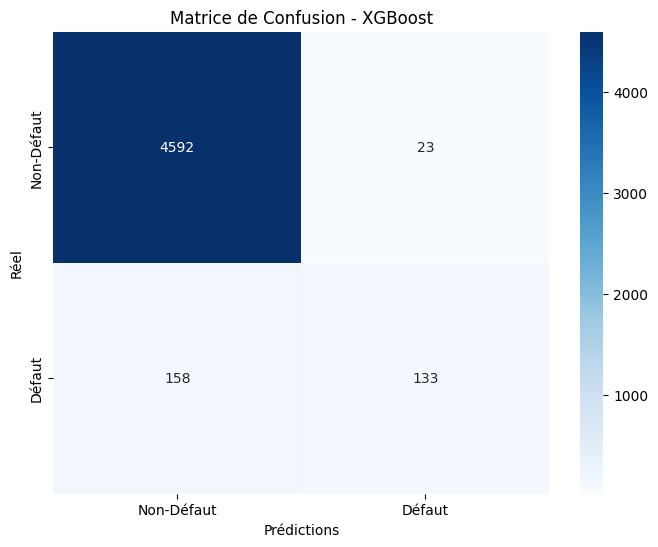

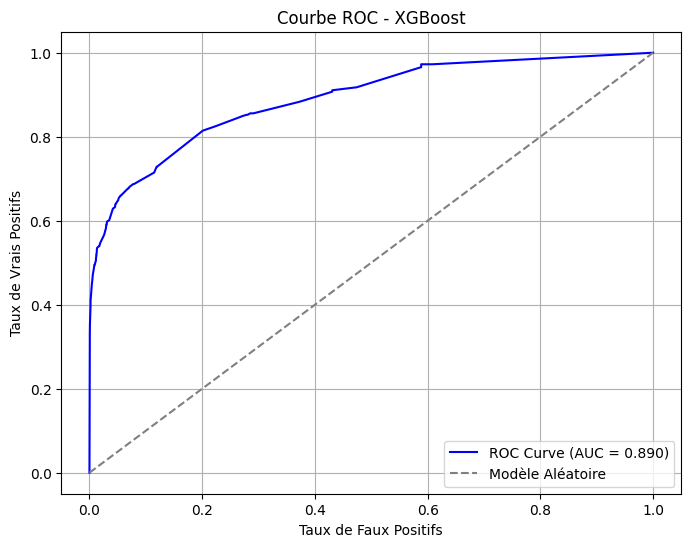

AUC PR: 0.615


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Initialisation du modèle avec des paramètres adaptés
xgb_model = XGBClassifier(
    objective="binary:logistic",  # Pour une classification binaire
    eval_metric="logloss",       # Log-loss comme métrique
    max_depth=3,                 # Profondeur des arbres
    learning_rate=0.005,           # Taux d'apprentissage
    subsample=0.8,               # Échantillonnage pour chaque arbre
    colsample_bytree=0.8,        # Échantillonnage des colonnes
    n_estimators=500             # Nombre maximal d'arbres
)

# Entraînement du modèle
xgb_model.fit(
    X_train_encoded, 
    y_train, 
    eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
    verbose=0                  # Désactive les journaux pendant l'entraînement
)

# Prédictions sur l'ensemble de test
y_pred_prob = xgb_model.predict_proba(X_test_encoded)[:, 1]  # Probabilité de la classe positive
y_pred = xgb_model.predict(X_test_encoded)                  # Classe prédite

# Évaluation du modèle
auc = roc_auc_score(y_test, y_pred_prob)
gini = (2 * auc) - 1
print(f"AUC: {auc:.3f}")
print(f"GINI: {gini:.3f}")

# Matrice de confusion
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion - XGBoost')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Courbe ROC
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Modèle Aléatoire")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### xgboost sans la discrétisation des variables

In [12]:
train = pd.read_excel('../data/tr.xlsx')
test = pd.read_excel('../data/te.xlsx')
oot = pd.read_excel('../data/o.xlsx')

AUC scores pour chaque pli : [0.8764721663313213, 0.890820004598003, 0.874039345769837, 0.88378612716763, 0.8731791907514451]
Moyenne de l'AUC (validation croisée) : 0.880
Écart-type de l'AUC : 0.007
AUC: 0.899
GINI: 0.798


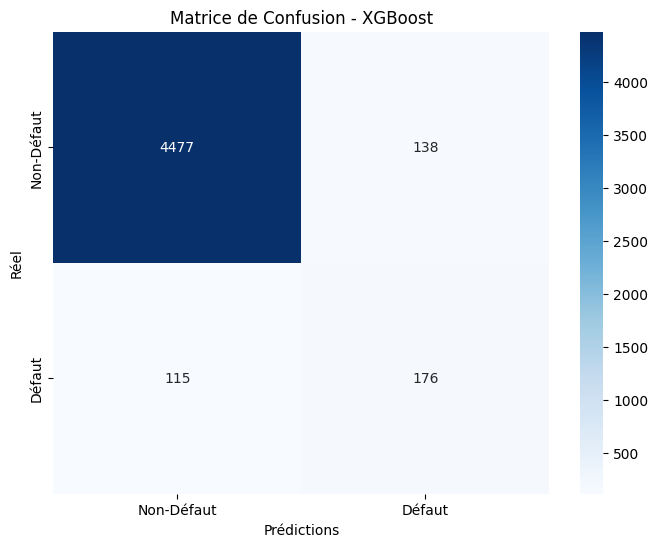

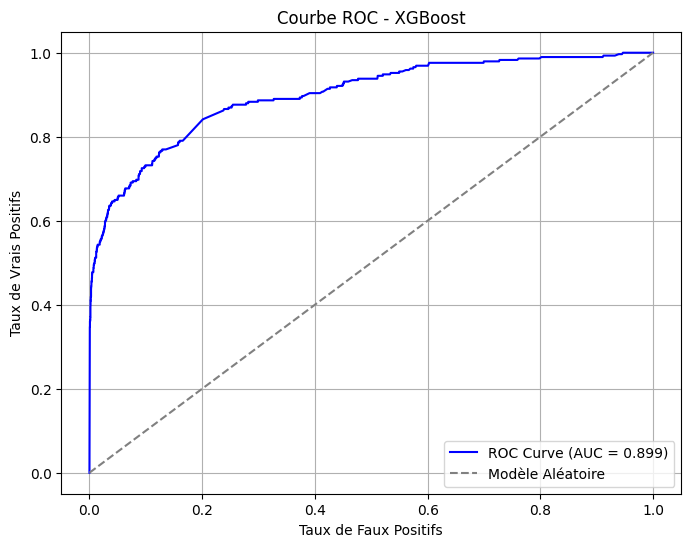

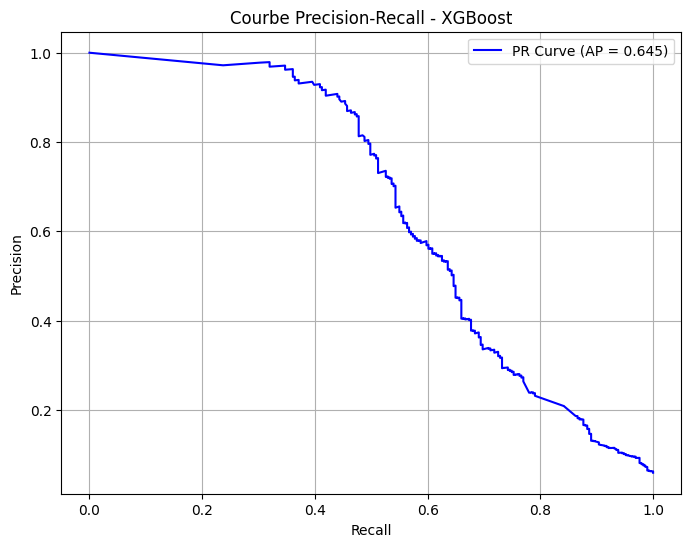

AUC PR: 0.645


In [ ]:
variables = train.columns.tolist()
variables.remove('DDefaut_NDB')  # 'DDefaut_NDB' est la variable cible

X_train = train[variables]
X_test = test[variables]
X_oot = oot[variables]

y_train = train['DDefaut_NDB']
y_test = test['DDefaut_NDB']
y_oot = oot['DDefaut_NDB']

#  Standardisation des variables explicatives (centrage et réduction)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_oot_scaled = scaler.transform(X_oot)

# Initialisation du modèle XGBoost
xgb_model = XGBClassifier(
    objective="binary:logistic",  # Pour une classification binaire
    eval_metric="logloss",       # Log-loss comme métrique
    max_depth=3,                 # Profondeur des arbres
    learning_rate=0.005,           # Taux d'apprentissage
    subsample=0.8,               # Échantillonnage pour chaque arbre
    colsample_bytree=0.8,        # Échantillonnage des colonnes
    n_estimators=500,
    scale_pos_weight = 7)
                      

# Validation croisée avec StratifiedKFold pour une division équilibrée des classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 plis pour la validation croisée

# Initialisation de la liste pour stocker les AUC pour chaque pli
cv_auc_scores = []

# Validation croisée manuelle
for train_index, val_index in cv.split(X_train_scaled, y_train):
    # Séparer les données en train et validation
    X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entraîner le modèle sur le sous-ensemble d'entraînement
    xgb_model.fit(X_cv_train, y_cv_train, verbose=False)
    
    # Prédictions sur le sous-ensemble de validation
    y_pred_prob = xgb_model.predict_proba(X_cv_val)[:, 1]  # Probabilité pour la classe positive
    
    # Calculer l'AUC pour ce pli
    auc_score = roc_auc_score(y_cv_val, y_pred_prob)
    cv_auc_scores.append(auc_score)

# Affichage des résultats de la validation croisée
print(f"AUC scores pour chaque pli : {cv_auc_scores}")
print(f"Moyenne de l'AUC (validation croisée) : {np.mean(cv_auc_scores):.3f}")
print(f"Écart-type de l'AUC : {np.std(cv_auc_scores):.3f}")

# Entraînement du modèle sur l'ensemble complet d'entraînement
xgb_model.fit(
    X_train_scaled, 
    y_train, 
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=0   # Arrêt anticipé si la performance n'améliore pas pendant 50 itérations
)

# Prédictions sur l'ensemble de test
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probabilité de la classe positive
y_pred = xgb_model.predict(X_test_scaled)                  # Classe prédite

# Évaluation du modèle
auc = roc_auc_score(y_test, y_pred_prob)
gini = (2 * auc) - 1
print(f"AUC: {auc:.3f}")
print(f"GINI: {gini:.3f}")

# Matrice de confusion
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion - XGBoost')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Modèle Aléatoire")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {avg_precision:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - XGBoost")
plt.legend(loc="best")
plt.grid()
plt.show()

print(f"AUC PR: {avg_precision:.3f}")


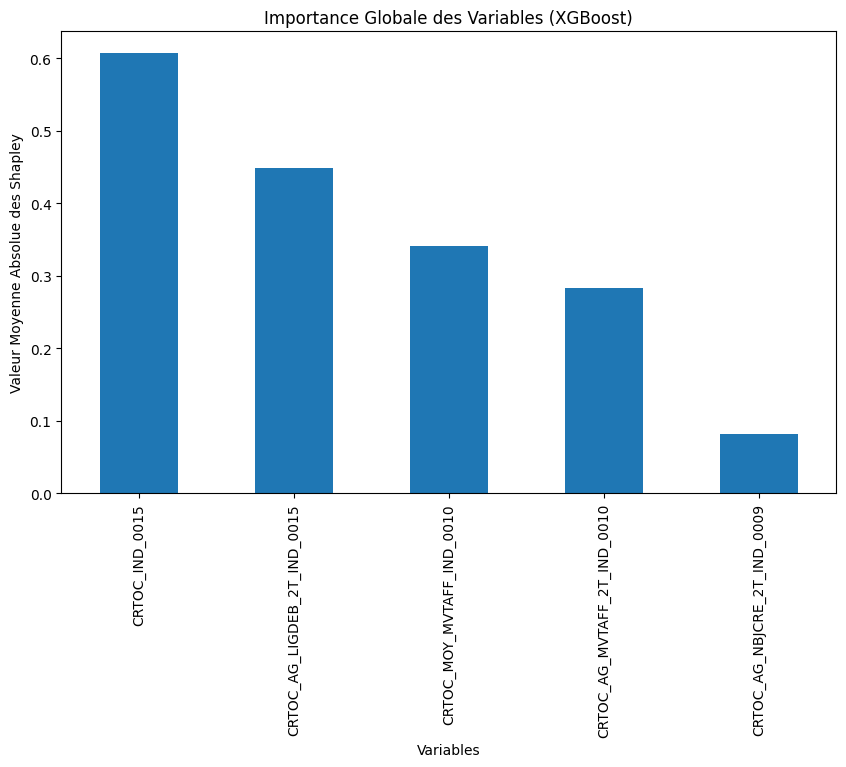

In [22]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_scaled)


# # Graphique Résumé pour XGBoost
# shap.summary_plot(xgb_shap_values, X_test_scaled, feature_names=X_test.columns, plot_type="dot", title="XGBoost - SHAP Summary")

# Histogramme Simpliﬁé des Valeurs de Shapley pour XGBoost
xgb_shap_df = pd.DataFrame(xgb_shap_values, columns=X_test.columns)
xgb_shap_df.abs().mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title="Importance Globale des Variables (XGBoost)")
plt.ylabel("Valeur Moyenne Absolue des Shapley")
plt.xlabel("Variables")
plt.show()